In [1]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import FormatStrFormatter


In [2]:
# obs. du har fjernet alle teams der ikke er i begge datasæt og som skifter conference imellem datasættene

def get_headers(soup): # Function that gets relevant headers
    headers = []
    results = soup.find(class_='thead2')
    ranks = results.find_all('th')
    for rank in ranks:
        text = rank.get_text()
        headers.append(text)
    headers.remove('AdjEM')
    return headers

def get_data(soup): # Function that gets the relevant data
	results = soup.find("tbody")
	list_of_list = []
	classes_body = ['hard_left', 'next_left', 'conf', 'wl', 'td-left']
	for cl in classes_body:
		list_ranks = []
		ranks = results.find_all("td", class_=cl)
		if cl == 'td-left':
			for rank in ranks:
				text = rank.get_text()
				list_ranks.append(text)
			for i in range(8):
				list_list = [float(i) for i in list_ranks[i::8]]
				list_of_list.append(list_list)
		else:
			for rank in ranks:
				text = rank.get_text()
				list_ranks.append(text)
			list_of_list.append(list_ranks)
	return list_of_list

def create_df(headers, data): # Combine headers 
    dictionary = dict(zip(headers, data))
    df = pd.DataFrame(dictionary)
    df['Team'] = df['Team'].str.replace('\d+', '')
    return df



In [3]:
scraper = cloudscraper.create_scraper()

# DATA FROM 2014
response14 = scraper.get("https://kenpom.com/index.php?y=2014")
soup = BeautifulSoup(response14.content, features="html.parser")  #soup 2014
df_2014 = create_df(get_headers(soup),get_data(soup))
df_2014['Team'] = df_2014['Team'].str.strip() # remove spacing

# DATA FROM 2009
response9 = scraper.get("https://kenpom.com/index.php?y=2009")
soup9 = BeautifulSoup(response9.content, features="html.parser")  #soup 2009
df_2009 = create_df(get_headers(soup9),get_data(soup9))
df_2009['Team'] = df_2009['Team'].str.strip() # remove spacing

In [4]:
print(df_2014['Conf'])

0      Amer
1       P12
2       SEC
3       ACC
4       B10
       ... 
346    SWAC
347    Slnd
348    BSth
349    SWAC
350    BSky
Name: Conf, Length: 351, dtype: object


In [5]:
def sort_as_dict(df, header):
	dictionary = {}
	for i,key in enumerate(df[header]):
		if not key in dictionary:
			dictionary[key] = []
		if key in dictionary:
			dictionary[key].append(i)
	return dictionary

In [6]:
conference_2014 = sort_as_dict(df_2014, 'Conf')
conference_2009 = sort_as_dict(df_2009, 'Conf')

conferences = ['ACC', 'SEC', 'B10', 'BSky', 'A10']


In [7]:
def plot_hist(df, header, title, figsize=(8,6), bin_width=10, xlabel=None, ylabel=None, mask=False, mask_name=False):
	if mask:
		data = df[header].iloc[mask].to_numpy(dtype=np.float64)
		num_bin = int(np.ceil((np.max(data)-np.min(data))/bin_width))

		fig, ax = plt.subplots(figsize=figsize)
		bins = np.histogram_bin_edges(df[header].iloc[mask].to_numpy(dtype=np.float64), bins=num_bin)

		sns.histplot(x=header, data=df.iloc[mask], hue=mask_name, hue_order=conferences, multiple = "dodge", ax=ax, bins=bins)
		
	else:
		data = df[header].to_numpy(dtype=np.float64)
		num_bin = int(np.ceil((np.max(data)-np.min(data))/bin_width))

		fig, ax = plt.subplots(figsize=figsize)
		bins = np.histogram_bin_edges(df[header].to_numpy(dtype=np.float64), bins=num_bin)

		sns.histplot(x=header, data=df, hue=mask_name, multiple = "dodge", ax=ax, bins=bins)

	ticks = [np.min(data)+(i*bin_width/2) for i in np.arange(1,num_bin*2,2)]
	ax.set_xticks(bins)
	ax.tick_params('x',top=True, labeltop=True, bottom=False, labelbottom=False)
	ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

	tick_names = [f'{int(ticks[i]-(bin_width/2))}-{int(ticks[i]+(bin_width/2))}' for i in range(len(ticks))]
	bin_centers = 0.5 * np.diff(bins) + bins[:-1]
	for tick_name, x in zip(tick_names, bin_centers):
		ax.annotate(tick_name, xy=(x, 0.04), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center', fontsize=15)

	ax.set_title(title)
	if xlabel:
		ax.set_xlabel(xlabel)
	if ylabel:
		ax.set_ylabel(ylabel)
	sns.move_legend(ax, loc=(0.01,0.65))
	ax.margins(x=0)
	ax.xaxis.labelpad = 20
	ax.grid(axis='x',linewidth=5, linestyle='-', alpha=1)
	fig.show()


<ipython-input-7-b5e20e8cf5bd>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


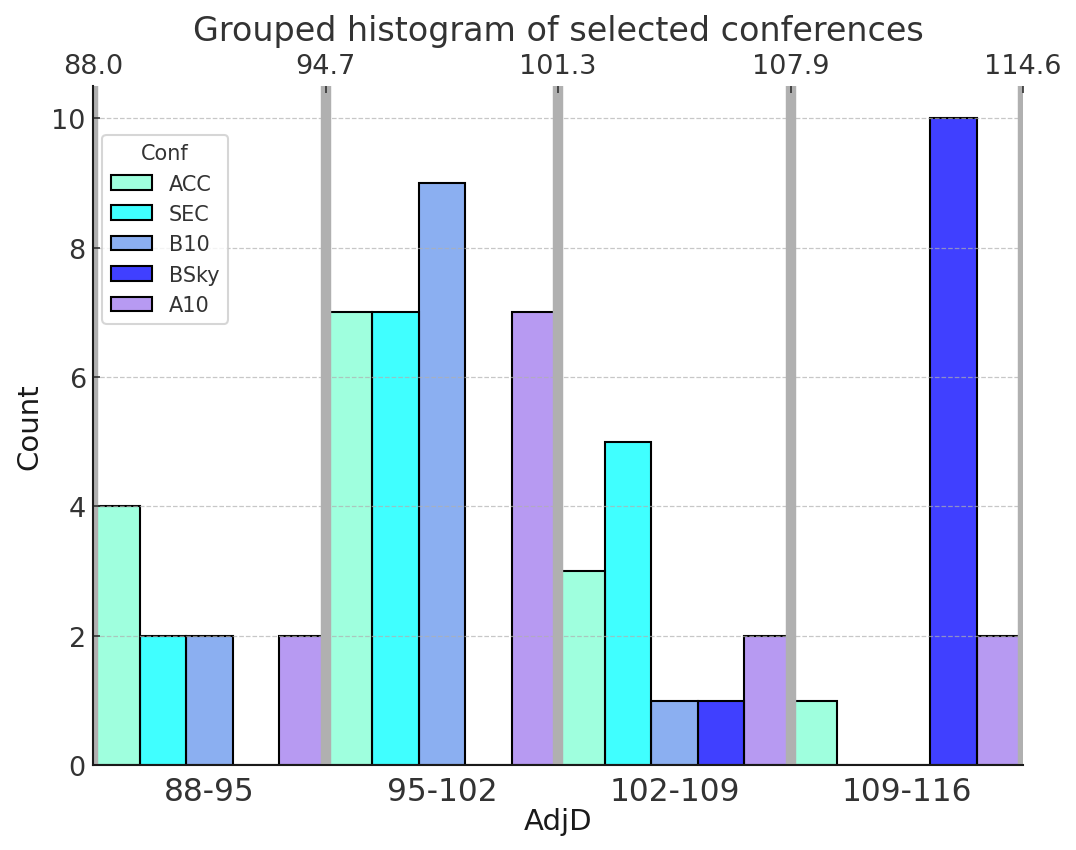

In [8]:
bool_mask_2014 = [conf in np.array(conferences) for conf in df_2014["Conf"]]
bool_mask_2009 = [conf in np.array(conferences) for conf in df_2009["Conf"]]

plt.style.use(r'/Users/emilieelisabethmilannielsen/Documents/Uni/4. år/Advanced Applied Statistics/AMAS/github/AMAS2023/emilie/afleveringer/plotting_style.mplstyle')

plot_hist(df_2014, 'AdjD', 'Grouped histogram of selected conferences', mask=bool_mask_2014, bin_width=7, mask_name='Conf')

In [9]:
dfmerge = df_2014.merge(df_2009, left_on='Team', right_on='Team',suffixes=('_2014','_2009')).reset_index(drop=True)
dfmerge['AdjO_diff'] = dfmerge['AdjO_2014']-dfmerge['AdjO_2009']
bool_mask_merge = np.array([conf in np.array(conferences) for conf in dfmerge["Conf_2014"]])
df_merged_selected_conf = dfmerge.iloc[bool_mask_merge,:]
df_merged_rest = dfmerge.iloc[~bool_mask_merge,:]
conference_merged_selected_conf = sort_as_dict(df_merged_selected_conf, 'Conf_2014')

AdjO_diff = np.abs(dfmerge['AdjO_diff'].iloc[bool_mask_merge].to_numpy(dtype=np.float64))

#display(df_merged_selected_conf)

<ipython-input-10-de039a99a0ca>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


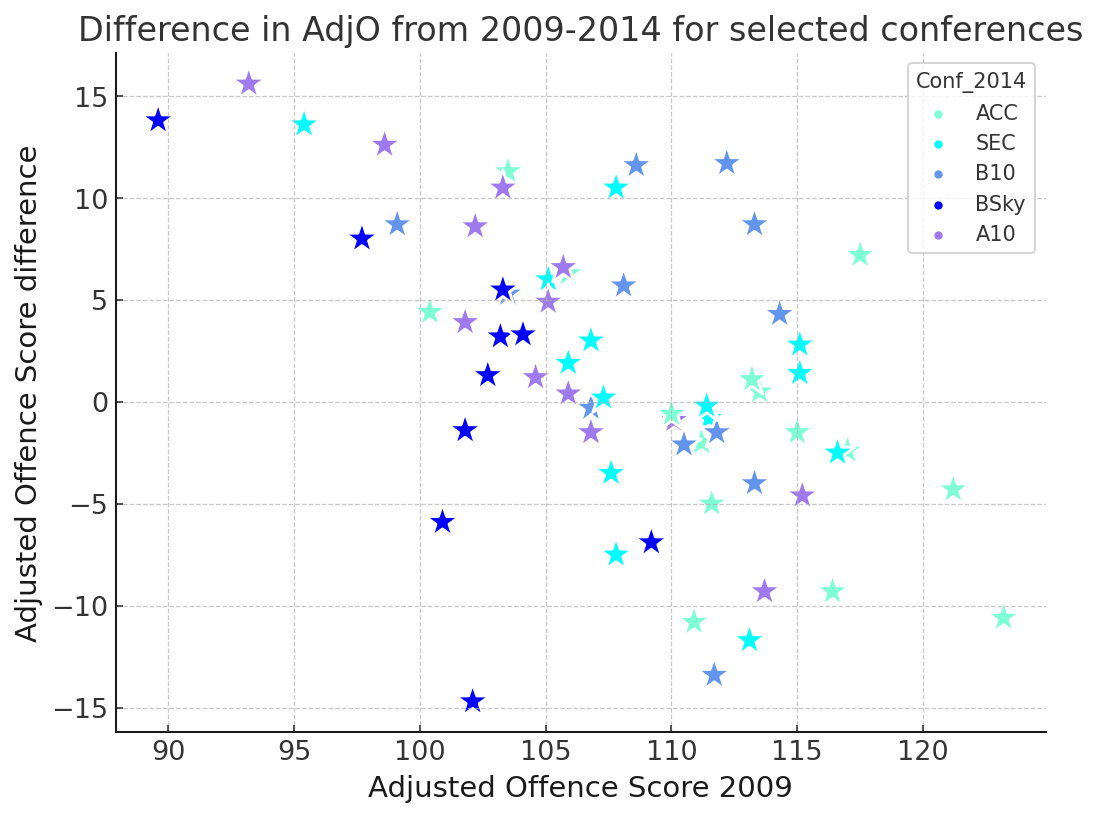

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_merged_selected_conf, x='AdjO_2009', y='AdjO_diff', hue='Conf_2014', hue_order=conferences, ax=ax, s=300, marker = '*')
ax.set_title('Difference in AdjO from 2009-2014 for selected conferences')
ax.set_xlabel('Adjusted Offence Score 2009')
ax.set_ylabel('Adjusted Offence Score difference')
fig.show()


In [11]:
mean_rest = np.mean(df_merged_rest['AdjO_diff'])
median_rest = np.median(df_merged_rest['AdjO_diff'])

conf_mean = {}
conf_median = {}

for i,key in enumerate(df_merged_selected_conf['Conf_2014']):
	if not key in conf_mean:
		conf_mean[key] = []
		conf_median[key] = []

	if key in conf_mean:
		conf_mean[key].append(df_merged_selected_conf['AdjO_diff'].iloc[i])
		conf_median[key].append(df_merged_selected_conf['AdjO_diff'].iloc[i])

for k, v in conf_mean.items():
    conf_mean[k] = np.mean(v)
for k, v in conf_median.items():
    conf_median[k] = np.median(v)


In [12]:
print(conf_mean)
print(conf_median)
print(mean_rest)
print(median_rest)



{'SEC': 0.9428571428571441, 'ACC': -1.0466666666666697, 'B10': 2.891666666666668, 'A10': 3.6923076923076925, 'BSky': 0.6200000000000031}
{'SEC': 0.8000000000000043, 'ACC': -1.5, 'B10': 4.799999999999997, 'A10': 3.9000000000000057, 'BSky': 2.25}
2.572661870503597
1.8500000000000014


<ipython-input-7-b5e20e8cf5bd>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


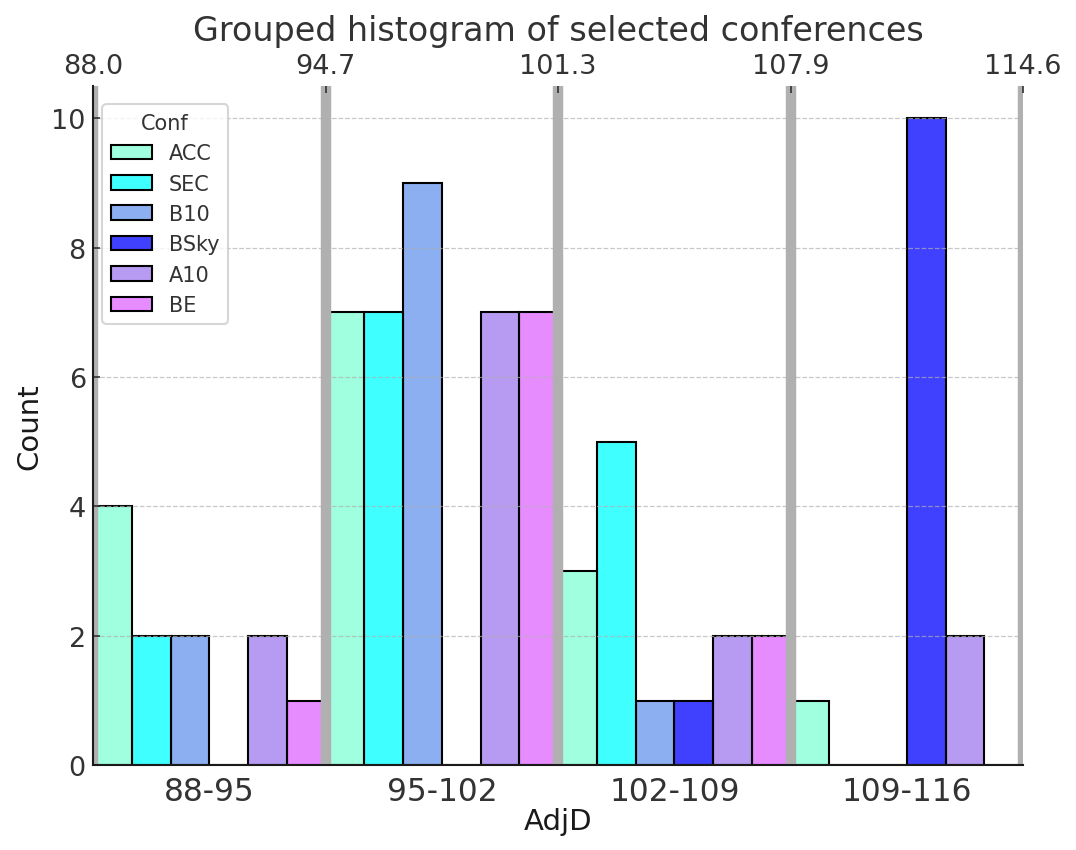

In [13]:
conferences = ['ACC', 'SEC', 'B10', 'BSky', 'A10', 'BE']

bool_mask_2014 = [conf in np.array(conferences) for conf in df_2014["Conf"]]
bool_mask_2009 = [conf in np.array(conferences) for conf in df_2009["Conf"]]

plt.style.use(r'/Users/emilieelisabethmilannielsen/Documents/Uni/4. år/Advanced Applied Statistics/AMAS/github/AMAS2023/emilie/afleveringer/plotting_style.mplstyle')

plot_hist(df_2014, 'AdjD', 'Grouped histogram of selected conferences', mask=bool_mask_2014, bin_width=7, mask_name='Conf')


<ipython-input-14-4a4e660ccbce>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'SEC': 0.9428571428571441, 'ACC': -1.0466666666666697, 'B10': 2.891666666666668, 'BE': 1.7899999999999991, 'A10': 3.6923076923076925, 'BSky': 0.6200000000000031}
{'SEC': 0.8000000000000043, 'ACC': -1.5, 'B10': 4.799999999999997, 'BE': 1.9000000000000057, 'A10': 3.9000000000000057, 'BSky': 2.25}
2.6018656716417903
1.5


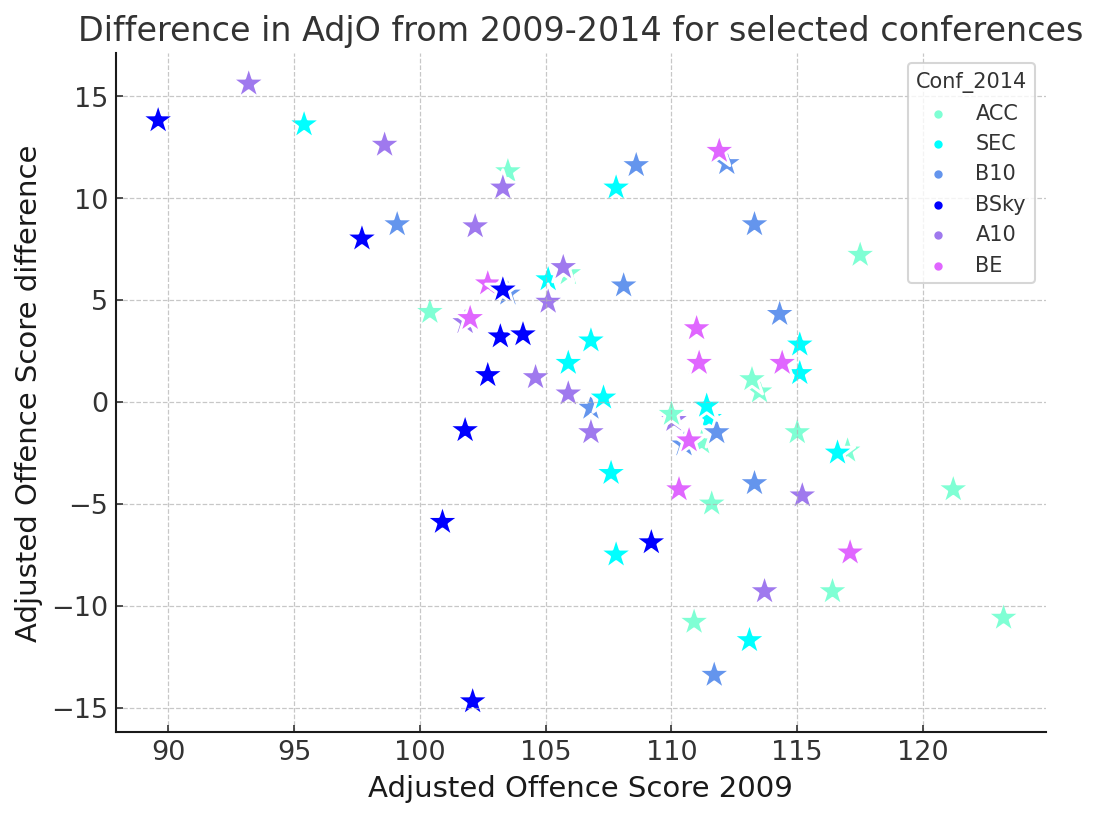

In [14]:
dfmerge = df_2014.merge(df_2009, left_on='Team', right_on='Team',suffixes=('_2014','_2009')).reset_index(drop=True)
dfmerge['AdjO_diff'] = dfmerge['AdjO_2014']-dfmerge['AdjO_2009']
bool_mask_merge = np.array([conf in np.array(conferences) for conf in dfmerge["Conf_2014"]])
df_merged_selected_conf = dfmerge.iloc[bool_mask_merge,:]
df_merged_rest = dfmerge.iloc[~bool_mask_merge,:]
conference_merged_selected_conf = sort_as_dict(df_merged_selected_conf, 'Conf_2014')

AdjO_diff = np.abs(dfmerge['AdjO_diff'].iloc[bool_mask_merge].to_numpy(dtype=np.float64))

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_merged_selected_conf, x='AdjO_2009', y='AdjO_diff', hue='Conf_2014', hue_order=conferences, ax=ax, s=300 , marker = '*')
ax.set_title('Difference in AdjO from 2009-2014 for selected conferences')
ax.set_xlabel('Adjusted Offence Score 2009')
ax.set_ylabel('Adjusted Offence Score difference')
fig.show()

mean_rest = np.mean(df_merged_rest['AdjO_diff'])
median_rest = np.median(df_merged_rest['AdjO_diff'])

conf_mean = {}
conf_median = {}

for i,key in enumerate(df_merged_selected_conf['Conf_2014']):
	if not key in conf_mean:
		conf_mean[key] = []
		conf_median[key] = []

	if key in conf_mean:
		conf_mean[key].append(df_merged_selected_conf['AdjO_diff'].iloc[i])
		conf_median[key].append(df_merged_selected_conf['AdjO_diff'].iloc[i])

for k, v in conf_mean.items():
    conf_mean[k] = np.mean(v)
for k, v in conf_median.items():
    conf_median[k] = np.median(v)

print(conf_mean)
print(conf_median)
print(mean_rest)
print(median_rest)